# Práctica 2

In [3]:
import numpy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal

### Funciones generales:

In [4]:
def cargar(nombre):
    img = Image.open(nombre).convert(mode='L')
    return np.array(img)


def mostrar(imagen, titulo=""):
    plt.figure(figsize=(9, 9))
    if (titulo): plt.title(titulo)
    plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)


def pasarALog(imagen):
    c = 255 / np.log(1 + np.max(imagen))
    resultado = np.uint8(c * np.log(1 + imagen))
    return resultado


# valor entre 0 y 255
def aplicar_umbral(imagen, valor):
    return np.uint8(np.greater(imagen, valor) * 255)


# suavizado:
def suavizado_promedio(imagen, dimension):
    H = np.ones((dimension, dimension)) / dimension ** 2
    return signal.convolve2d(imagen, H, boundary="symm", mode="same")


def eqHist(imagen):
    hist = np.histogram(imagen, 256, range=(0, 256))
    acumulado = np.cumsum(hist[0])
    normalizado = 255 * ((acumulado - acumulado.min()) / (acumulado.max() - acumulado.min()))
    resultado = np.uint8(normalizado[imagen])
    return resultado

### Ejercicio 1 (verificación)

In [5]:
# verificación 2.c
x = np.array([0, 2, -1, 0, 0, 0])
h = np.array([0, -1, 2, 1, 0])

signal.convolve(h, x)

array([ 0,  0, -2,  5,  0, -1,  0,  0,  0,  0])

### Ejercicio 2 (verificación)

In [25]:
# 2 i
x = np.array([[0, -1, 1], [-1, 4, -1], [0, -1, 0]])
h = np.array([[1, 4, 1], [2, 5, 3]])
signal.convolve2d(x, h, boundary="fill", fillvalue=0)

array([[ 0, -1, -3,  3,  1],
       [-1, -2, 11,  2,  2],
       [-2,  2, 11,  6, -3],
       [ 0, -2, -5, -3,  0]])

### Ejercicio 3

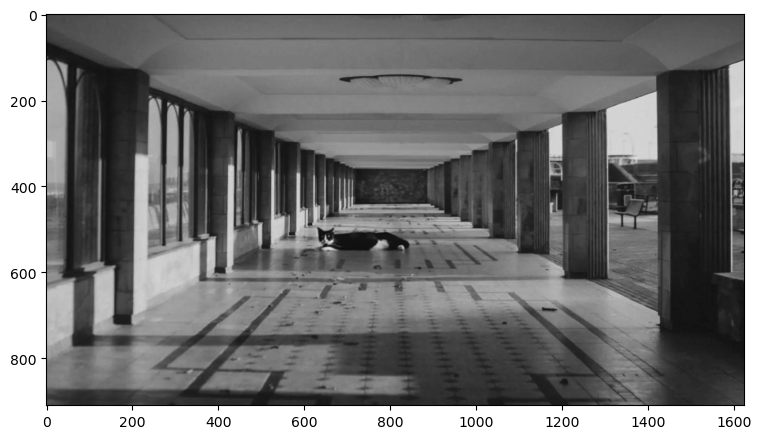

In [10]:
imagenA = cargar("imagen2.png")
mostrar(imagenA)

In [6]:
def ventana_gauss(dimension, desviacion):
    gauss1d = signal.windows.gaussian(dimension, desviacion)
    gauss2d = np.outer(gauss1d, gauss1d)
    return gauss2d / sum(sum(gauss2d))

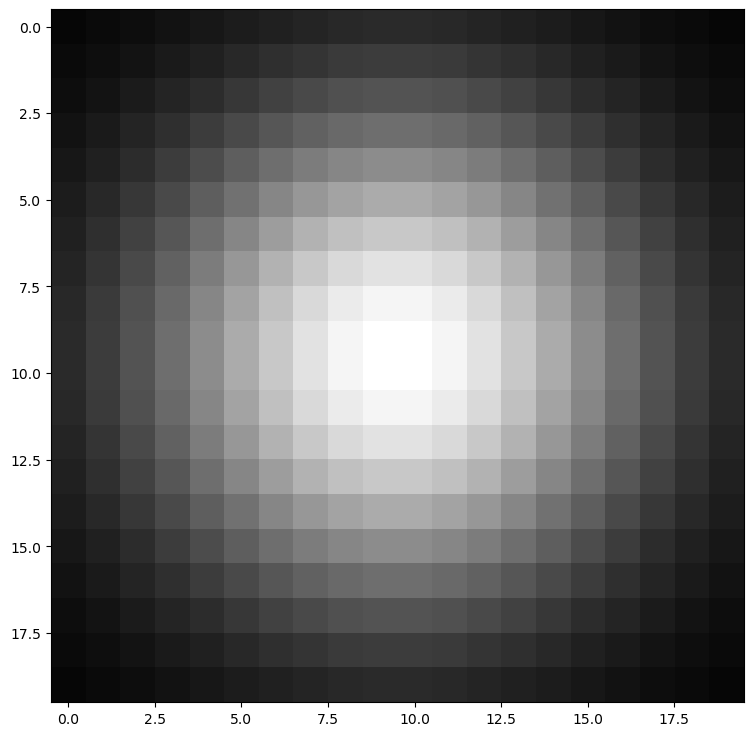

In [241]:
gauss = ventana_gauss(20, 5)
mostrar(pasarALog(gauss))

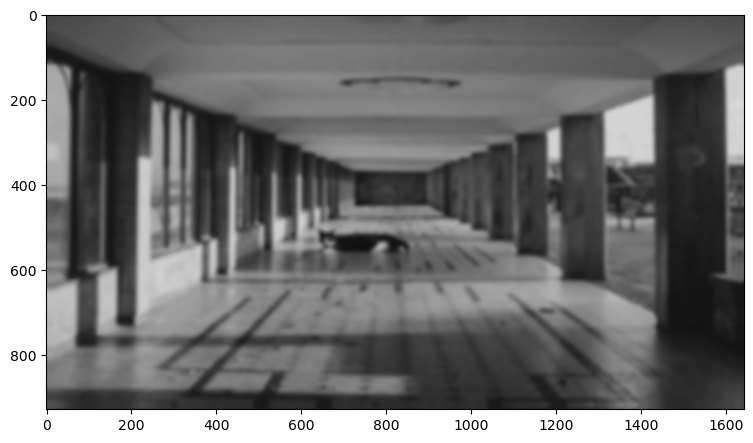

In [242]:
suave = signal.convolve2d(imagenA, gauss, boundary="symm")
mostrar(suave)

In [303]:
def suavizado_gauss(imagen, std):
    gauss = ventana_gauss(int(4 * std), std)
    return signal.convolve2d(imagen, gauss, boundary="symm", mode="same")

In [304]:
def sharpen(imagen, std, cantidad):
    gauss = ventana_gauss(int(4 * std), std)
    suave = signal.convolve2d(imagen, gauss, boundary="symm", mode="same")
    diferencia = imagen - suave
    return imagen + cantidad * diferencia

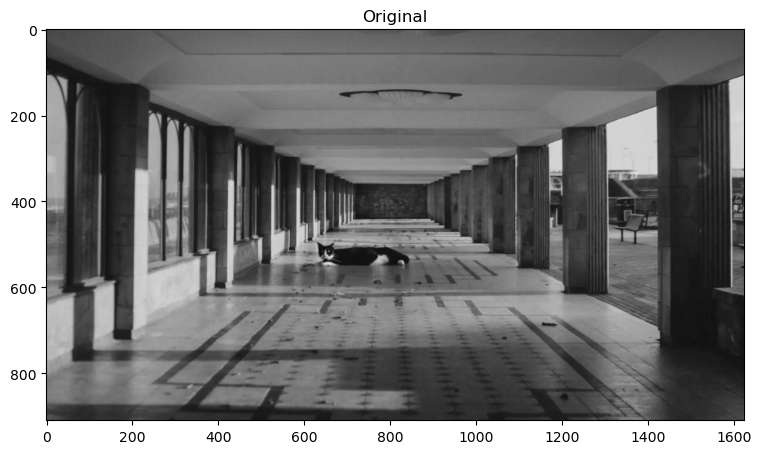

In [305]:
mostrar(imagenA, "Original")

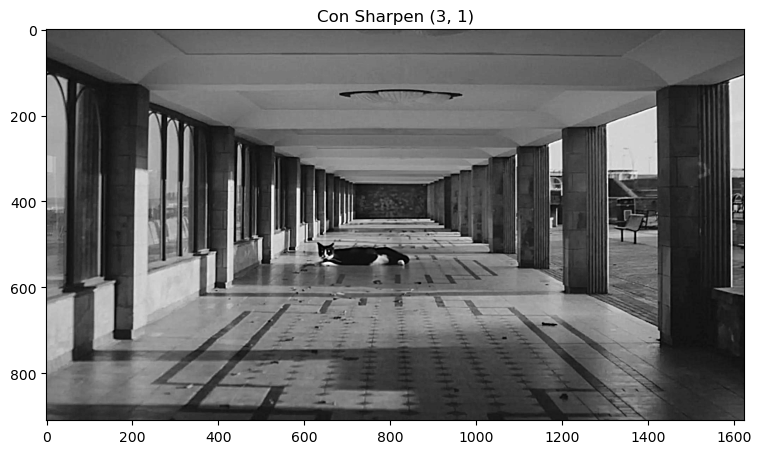

In [249]:
mostrar(sharpen(imagenA, 3, 1), "Con Sharpen (3, 1)")

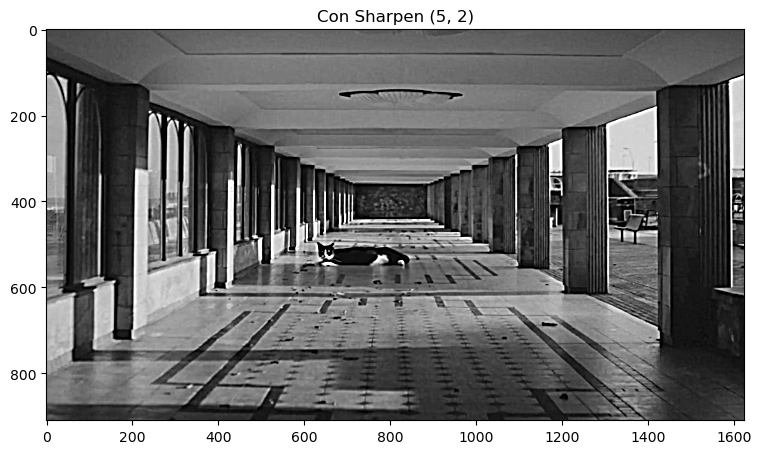

In [246]:
mostrar(sharpen(imagenA, 5, 2), "Con Sharpen (5, 2)")

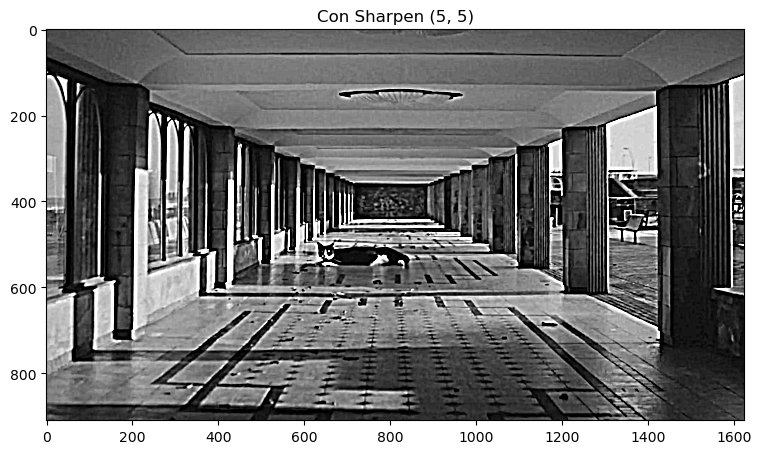

In [247]:
mostrar(sharpen(imagenA, 5, 5), "Con Sharpen (5, 5)")

### Ejercicio 4

In [250]:
robertsNW = np.array([[-1, 0], [0, 1]])
robertsNE = np.flip(robertsNW, axis=1)

prewitt_H = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
prewitt_V = prewitt_H.T

sobel_H = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
sobel_V = sobel_H.T

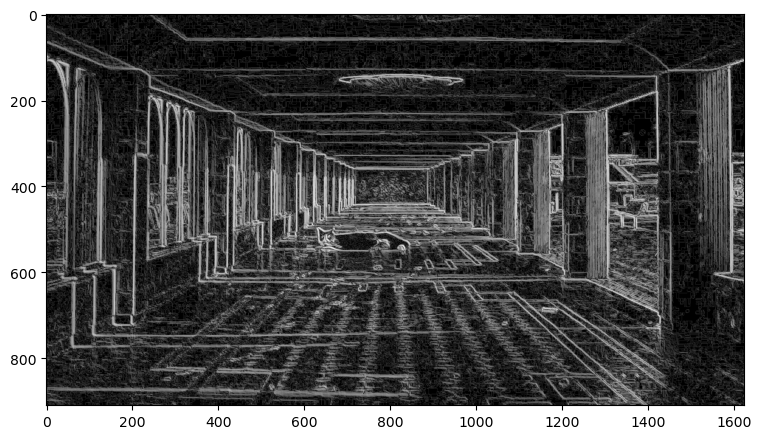

In [298]:
prueba1 = signal.convolve2d(imagenA, robertsNE, boundary="symm", mode="same")
# prueba1 = prueba1 + abs(np.min(prueba1))
# prueba = np.abs(prueba)
mostrar(pasarALog(np.abs(prueba1)))

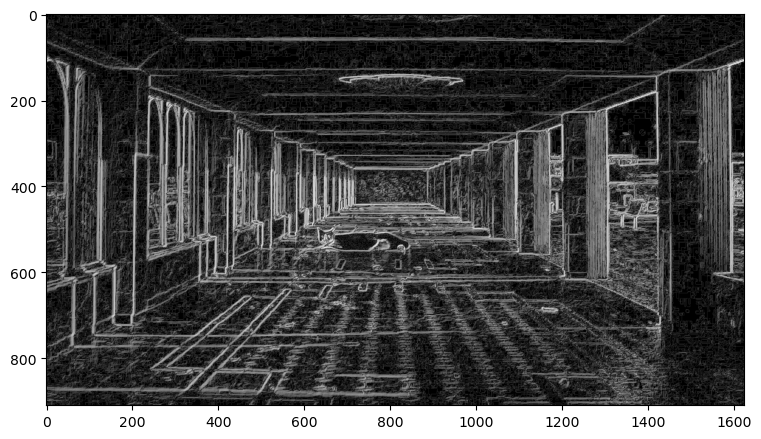

In [300]:
prueba = signal.convolve2d(imagenA, robertsNW, boundary="symm", mode="same")
# prueba = prueba + abs(np.min(prueba))
# prueba = np.abs(prueba)
mostrar(pasarALog(np.abs(prueba)))

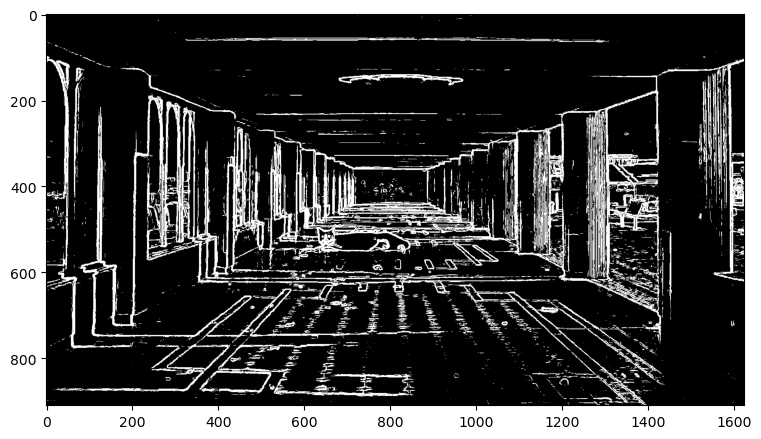

In [309]:
mostrar(aplicar_umbral(pasarALog(np.abs(prueba) + np.abs(prueba1)), 130))

In [40]:
def bordes_gradiente(imagen, umbral, metodo="roberts"):
    #roberts:
    h1 = np.array([[-1., 0.], [0., 1.]])
    h2 = np.flip(h1, axis=1)

    if metodo == "prewitt":
        h1 = np.array([[-1., -1., -1.], [0., 0., 0.], [1., 1., 1.]])
        h2 = h1.T

    if metodo == "sobel":
        h1 = np.array([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]])
        h2 = h1.T

    im1 = signal.convolve2d(imagen, h1, boundary="symm", mode="same")
    im2 = signal.convolve2d(imagen, h2, boundary="symm", mode="same")

    imagen_res = np.abs(im1) + np.abs(im2)

    return aplicar_umbral(imagen_res, umbral)


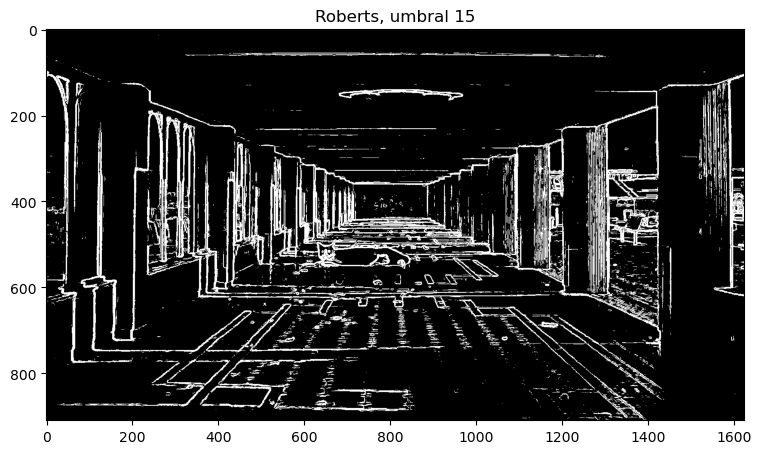

In [41]:
mostrar(bordes_gradiente(imagenA, 15), titulo="Roberts, umbral 15")

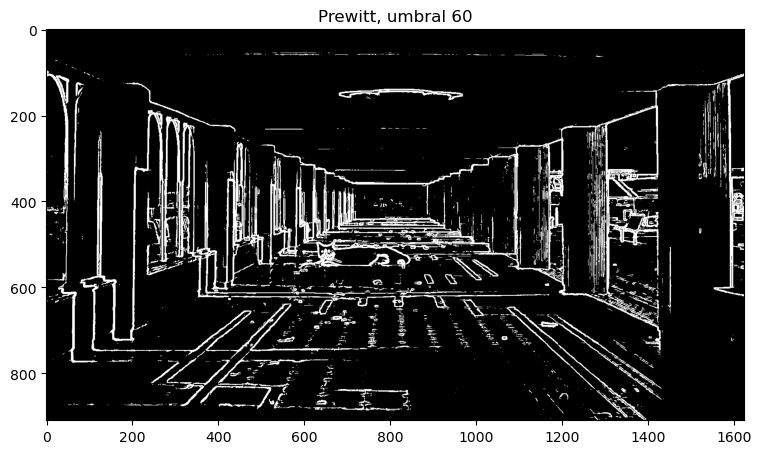

In [42]:
mostrar(bordes_gradiente(imagenA, 60, metodo="prewitt"), titulo="Prewitt, umbral 60")

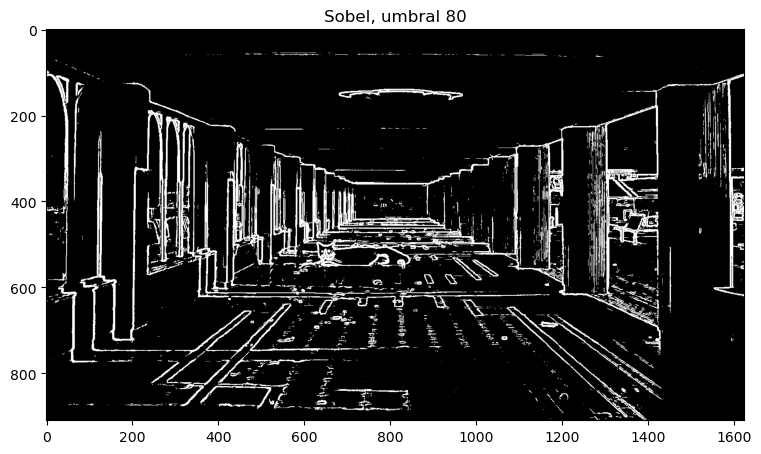

In [43]:
mostrar(bordes_gradiente(imagenA, 80, metodo="sobel"), titulo="Sobel, umbral 80")

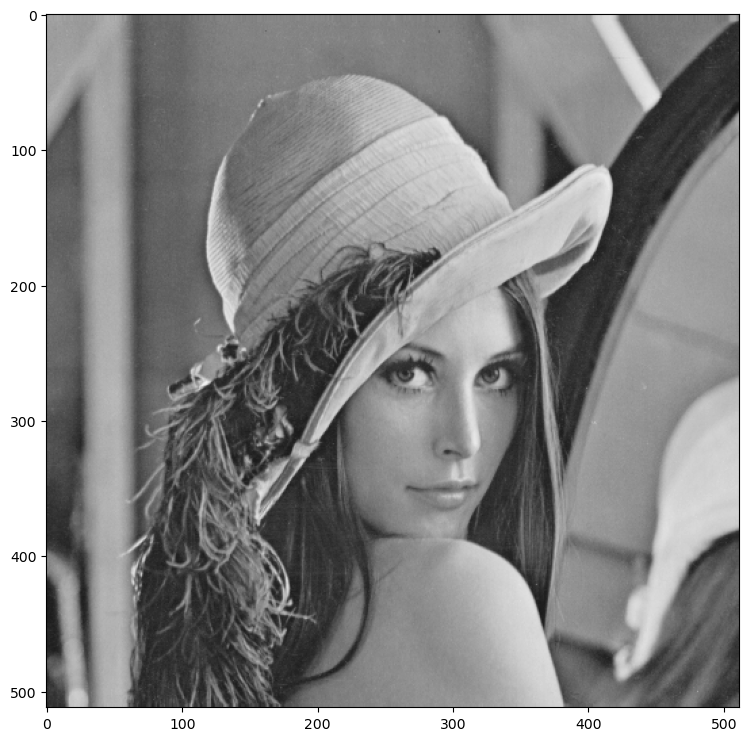

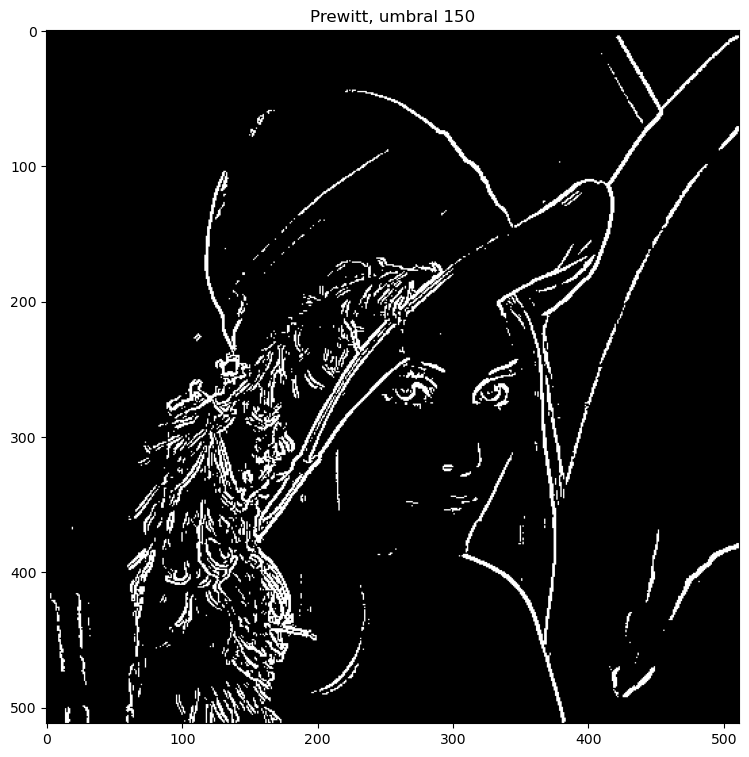

In [44]:
lena = cargar("lena.png")
mostrar(lena)
mostrar(bordes_gradiente(lena, 150, metodo="prewitt"), titulo="Prewitt, umbral 150")

### Ejercicio 5

In [219]:
def zero_crossing(matriz3x3):
    eps = 0.01
    ceros = np.abs(matriz3x3) < eps
    signos = np.sign(matriz3x3)

    horizontal = signos[0, :] + signos[2, :]
    vertical = signos[:, 0] + signos[:, 2]

    bool_h = horizontal == 0
    bool_v = vertical == 0

    bool_h = np.logical_and(bool_h, np.logical_not(ceros[0, :]))
    # bool_h = np.logical_and(bool_h, np.logical_not(ceros[2,:]))

    bool_v = np.logical_and(bool_v, np.logical_not(ceros[:, 0]))
    # bool_v = np.logical_and(bool_v, np.logical_not(ceros[:,2]))

    return sum(bool_v) > 1 or sum(bool_h) > 1


In [241]:

def bordes_laplaciano(imagen):
    laplaciano = np.array([[0., 1., 0.], [1., -4., 1.], [0., 1., 0.]])
    eps = 0.1
    convolucion = signal.convolve2d(imagen, laplaciano, boundary="symm")
    resultado = np.zeros(imagen.shape)

    N, M = convolucion.shape
    for i in range(1, N - 1):
        for j in range(1, M - 1):
            resultado[i - 1, j - 1] = zero_crossing(convolucion[i - 1: i + 2, j - 1: j + 2])

    return resultado * 255


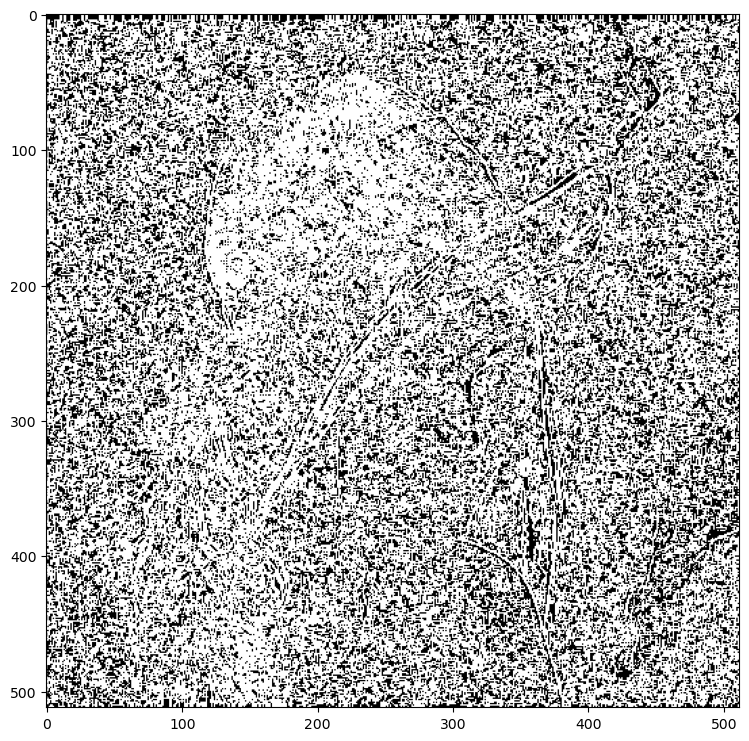

In [242]:
bordes_lena = bordes_laplaciano(lena)
mostrar(bordes_lena)


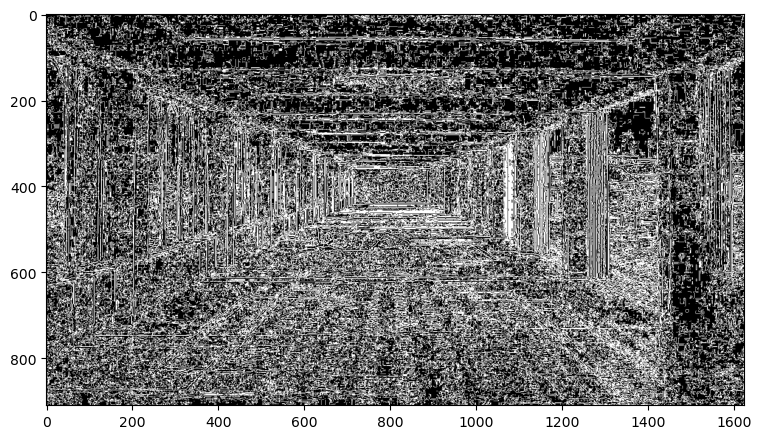

In [243]:
bordes_A = bordes_laplaciano(imagenA)
mostrar(bordes_A)


Con varianza:

In [244]:
def evalua_zero_con_varianza(ventana, umbral):
    centro = int((ventana.shape[0] - 1) / 2)
    es_zero_crossing = zero_crossing(ventana[centro - 1: centro + 2, centro - 1: centro + 2])
    if es_zero_crossing:
        diferencias = np.abs(ventana - ventana[centro, centro])
        varianza = sum(sum(diferencias))
        resultado = varianza >= umbral
    else:
        resultado = False
    return resultado

In [265]:
def bordes_laplaciano_varianza(imagen, umbral):
    laplaciano = np.array([[0., 1., 0.], [1., -4., 1.], [0., 1., 0.]])
    eps = 0.1
    
    convolucion = signal.convolve2d(imagen, laplaciano, boundary="symm")
    resultado = np.zeros(imagen.shape)
    #tamaño de la ventana para evaluar la varianza:
    ventana_local = 2
    N, M = convolucion.shape
    for i in range(ventana_local, N - ventana_local):
        for j in range(ventana_local, M - ventana_local):
            resultado[i - 1, j - 1] = evalua_zero_con_varianza(
                convolucion[i - ventana_local: i + 1 + ventana_local, j - ventana_local: j + 1 + ventana_local], umbral)

    return resultado * 255

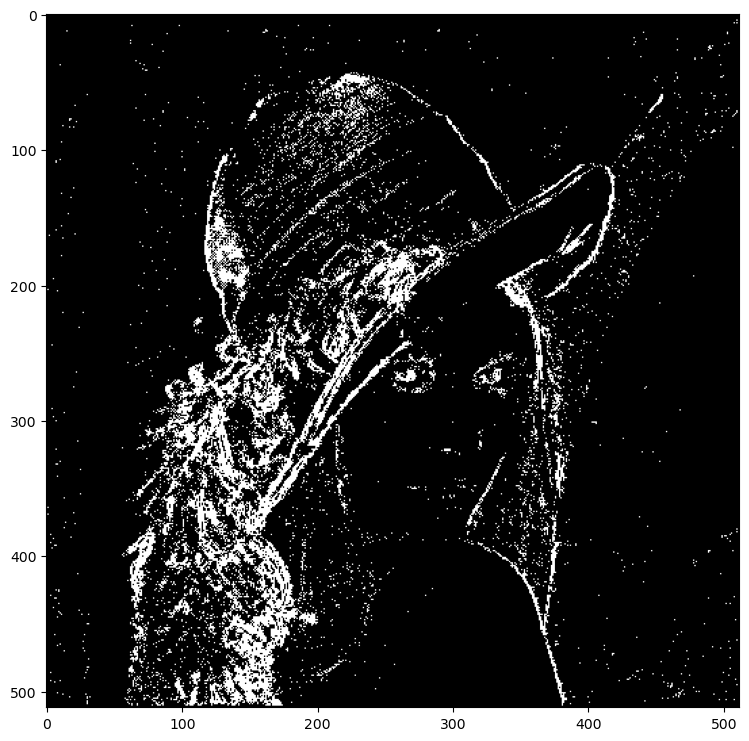

In [266]:
mostrar(bordes_laplaciano_varianza(lena, 800))

In [273]:
def bordes_laplaciano_varianza_suavizado(imagen, umbral):
    laplaciano = np.array([[0., 1., 0.], [1., -4., 1.], [0., 1., 0.]])
    eps = 0.1

    suave = suavizado_gauss(imagen, 2)

    convolucion = signal.convolve2d(suave, laplaciano, boundary="symm")
    resultado = np.zeros(imagen.shape)
    #tamaño de la ventana para evaluar la varianza:
    ventana_local = 2
    N, M = convolucion.shape
    for i in range(ventana_local, N - ventana_local):
        for j in range(ventana_local, M - ventana_local):
            resultado[i - 1, j - 1] = evalua_zero_con_varianza(
                convolucion[i - ventana_local: i + 1 + ventana_local, j - ventana_local: j + 1 + ventana_local], umbral)

    return resultado * 255

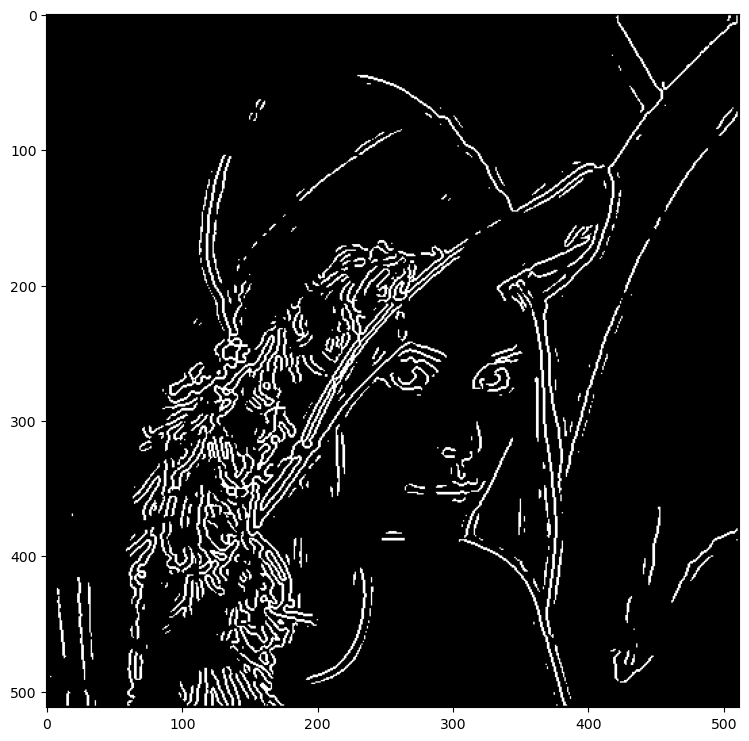

In [277]:
mostrar(bordes_laplaciano_varianza_suavizado(lena, 50))

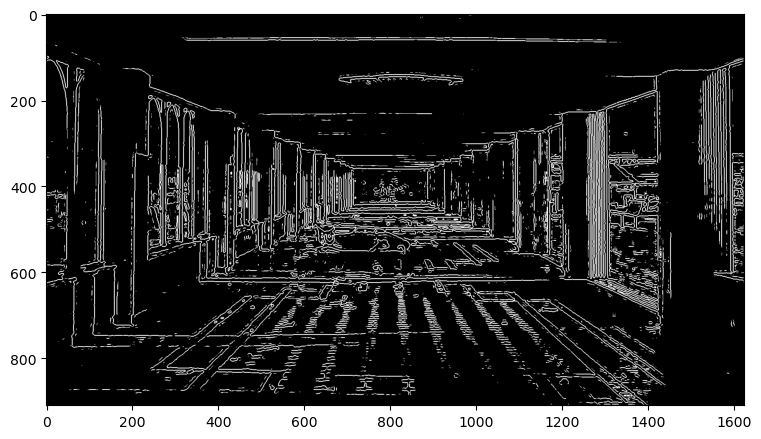

In [301]:
mostrar(bordes_laplaciano_varianza_suavizado(imagenA, 20))

In [298]:
np.random.rayleigh(0.06, (4, 4)) + 1

array([[1.1611967 , 1.15273419, 1.13063993, 1.10348669],
       [1.05401219, 1.02467736, 1.06136259, 1.04362049],
       [1.03198912, 1.01988299, 1.09649178, 1.00909678],
       [1.10295567, 1.03382778, 1.02442557, 1.02599801]])

In [284]:
np.random.normal(0, 5, (4, 4))

array([[ 0.33258611,  1.51235949, -3.17161047, -1.81370583],
       [-3.36230224, -1.79776581, -4.06573141, -8.63141301],
       [ 0.88713071, -2.00890468, -8.15099173,  2.31391128],
       [-4.53649182,  0.25972698,  3.64545281,  0.64491455]])